### Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import keras
import torch
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from warnings import warn

from PIL import Image

from keras import backend as K
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.layers import Conv2DTranspose
from keras.layers import Activation, Input, Reshape
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, History

from scipy.ndimage import uniform_filter, gaussian_filter
from skimage.util.dtype import dtype_range
from skimage.util.arraycrop import crop
from skimage._shared.utils import warn

Using TensorFlow backend.


### Reshape Dimensions

In [0]:
from transforms import corrupt_mnist_copy

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train_noisy = corrupt_mnist_copy(x_train)
x_test_noisy = corrupt_mnist_copy(x_test)

# Scale to [0, 1]
image_size = x_train.shape[1]
x_train = x_train.astype(K.floatx()) / 255.
x_test = x_test.astype(K.floatx()) / 255.
x_train_noisy = x_train_noisy.astype(K.floatx()) / 255.
x_test_noisy = x_test_noisy.astype(K.floatx()) / 255.

11493376/11490434 [==============================] - 1s 0us/step


# 1.   **Data Visualization**



[ORIGINAL DATA]


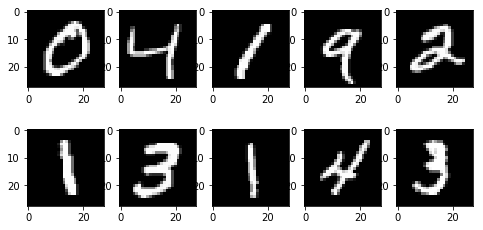

In [0]:
print("[ORIGINAL DATA]")
fig=plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i in range(1, columns*rows + 1):
    img = x_train[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

[CORRUPTED DATA]


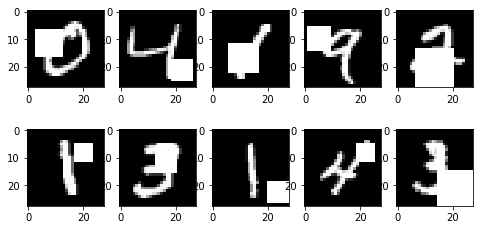

In [0]:
print("[CORRUPTED DATA]")
fig=plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i in range(1, columns*rows + 1):
    img = x_train_noisy[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

### Reshape Data

In [0]:
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test_noisy = np.reshape(x_test_noisy, [-1, image_size, image_size, 1])
x_train_noisy = np.reshape(x_train_noisy, [-1, image_size, image_size, 1])

In [0]:
# Network parameters
image_size = x_train.shape[1]
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16

In [0]:
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [0]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [0]:
# Shape info needed to build Decoder Model
shape = K.int_shape(x)

In [0]:
# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [0]:
# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')

In [0]:
# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [0]:
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

In [0]:
# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')

# 2.   **Model Summary**

[TEXT SUMMARY]

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


[IMAGE SUMMARY]



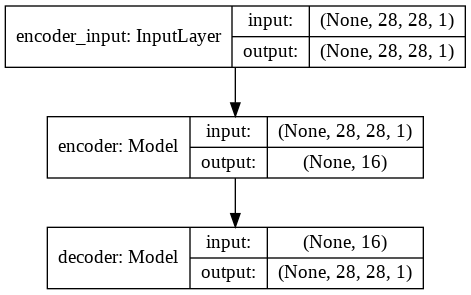

In [0]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

print("[TEXT SUMMARY]\n")
autoencoder.summary()

print("\n\n[IMAGE SUMMARY]\n")
plot_model(autoencoder, to_file = 'AE_mnist.png', show_shapes = True)

In [0]:
# checkpoint = ModelCheckpoint('mnist_cnn.h5',
#                             verbose=0, save_best_only=True, save_weights_only=True)
autoencoder.compile(loss='mse', optimizer='adam')

# 3.  **Plots of losses per epoch**











Training: 5 Epochs
dict_keys(['val_loss', 'loss'])


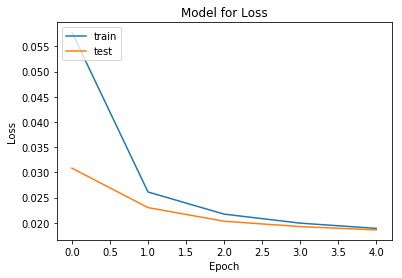

In [0]:
# Train the autoencoder
epochs = 5
history = autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=epochs,
                batch_size=batch_size, verbose=0)

print("Training:" , epochs , "Epochs")
autoencoder.history

# List all data in history
print(history.history.keys())
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model for Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

In [0]:
# Display at least 5 samples for the results
rows, cols = 1, 5
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# 4. **Results (5 Samples)**



	 [TOP ROW] Original Images
	 [MIDDLE ROW] Corrupted Images
	 [LAST ROW] Restored Images


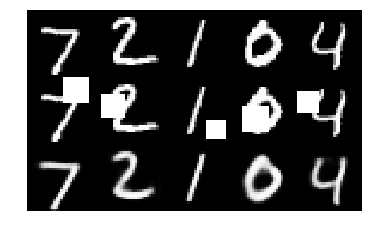

In [0]:
plt.axis('off')
print('\t [TOP ROW] Original Images\n\t [MIDDLE ROW] Corrupted Images\n\t [LAST ROW] Restored Images')
plt.imshow(imgs, interpolation='none', cmap='gray')
# Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

# 5. **Benchmark Output**



In [0]:
from benchmark_keras import test_model

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale to [0, 1]
x_test = x_test.astype(K.floatx()) / 255.

# model is your Keras model
# DO NOT convert y_test, i.e. don't use keras.utils.to_categorical()
# x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
# y_test = np.reshape(y_test, [-1, image_size, image_size, 1])
test_model(autoencoder, x_test, y_test, batch_size=100)

Classifier score: 98.38
SSIM score: 87.58
